**Name** : Gurmat Singh Sour
---
**ID** : n01715331


---
AIGC5005: **Midterm Project**

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [328]:
train_data = 'https://raw.githubusercontent.com/gurmatsinghsour/Risk-data/refs/heads/main/risk-train.txt'
test_data = 'https://raw.githubusercontent.com/gurmatsinghsour/Risk-data/refs/heads/main/risk-test.txt'

In [329]:
df = pd.read_csv(train_data, sep='\t')

In [330]:
df.head()

,ORDER_ID,CLASS,B_EMAIL,B_TELEFON,B_BIRTHDATE,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_METHODE,Z_CARD_ART,Z_CARD_VALID,...,FAIL_RPLZ,FAIL_RORT,FAIL_RPLZORTMATCH,SESSION_TIME,NEUKUNDE,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,DATE_LORDER,MAHN_AKT,MAHN_HOECHST
0,49917,no,yes,no,1/17/1973,yes,yes,check,?,5.2006,...,no,no,no,8,yes,0,0.00,?,?,?
1,49919,no,yes,yes,12/8/1970,no,no,credit_card,Visa,12.2007,...,yes,no,no,13,yes,0,0.00,?,?,?
2,49923,no,yes,no,4/3/1972,yes,no,check,?,12.2007,...,no,no,no,3,yes,0,0.00,?,?,?
3,49924,no,no,yes,8/1/1966,yes,no,check,?,1.2007,...,no,no,no,11,no,4,75.72,5/12/2002,0,0
4,49927,no,yes,yes,12/21/1969,yes,no,credit_card,Eurocard,12.2006,...,no,no,no,16,yes,0,0.00,?,?,?


In [331]:
df.replace('?', np.nan, inplace=True)

In [332]:
df.drop(columns=['ORDER_ID'], inplace=True)

In [333]:
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 18000])

Z_CARD_ART    18654
ANUMMER_02    22147
ANUMMER_03    26802
ANUMMER_04    28668
ANUMMER_05    29459
ANUMMER_06    29794
ANUMMER_07    29905
ANUMMER_08    29966
ANUMMER_09    29993
ANUMMER_10    30000
dtype: int64


In [334]:
df.shape

(30000, 43)

In [335]:
df.drop(columns=['ANUMMER_02', 'ANUMMER_03', 'ANUMMER_04', 'ANUMMER_05', 'ANUMMER_06', 'ANUMMER_07', 'ANUMMER_08', 'ANUMMER_09', 'ANUMMER_10', 'Z_CARD_ART'], inplace=True)

In [336]:
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
categorical_cols =[cname for cname in df.columns if df[cname].dtype == 'object']

In [337]:
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

In [338]:
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [339]:
x = df.drop(columns=['CLASS'])
y = df['CLASS']

In [340]:
num_cols = x.select_dtypes(include=[np.number]).columns
correlation_matrix = x[num_cols].corr().abs()
correlation_matrix

,Z_CARD_VALID,VALUE_ORDER,AMOUNT_ORDER,ANUMMER_01,SESSION_TIME,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE
Z_CARD_VALID,1.000000,0.000474,0.000461,0.008091,0.000527,0.001241,0.012250
VALUE_ORDER,0.000474,1.000000,0.792516,0.005586,0.016891,0.006140,0.005045
AMOUNT_ORDER,0.000461,0.792516,1.000000,0.007629,0.014331,0.005553,0.003536
ANUMMER_01,0.008091,0.005586,0.007629,1.000000,0.005365,0.005243,0.003022
SESSION_TIME,0.000527,0.016891,0.014331,0.005365,1.000000,0.000650,0.008615
AMOUNT_ORDER_PRE,0.001241,0.006140,0.005553,0.005243,0.000650,1.000000,0.656914
VALUE_ORDER_PRE,0.012250,0.005045,0.003536,0.003022,0.008615,0.656914,1.000000


In [341]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

to_drop

[]

In [342]:
if "B_BIRTHDATE" in x.columns:
    x["B_BIRTHDATE"] = pd.to_datetime(x["B_BIRTHDATE"], errors="coerce")
    current_year = pd.Timestamp.now().year
    x["AGE"] = current_year - x["B_BIRTHDATE"].dt.year
    x.drop(columns=["B_BIRTHDATE"], inplace=True)

In [343]:
x['AGE']

,AGE
0,52
1,55
2,53
3,59
4,56
...,...
29995,44
29996,53
29997,45
29998,45


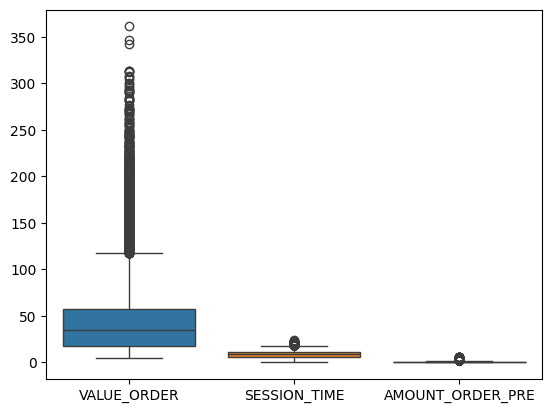

In [344]:
outlier_cols = ["VALUE_ORDER", "SESSION_TIME", "AMOUNT_ORDER_PRE"]
sns.boxplot(data=x[outlier_cols])
plt.show()

In [345]:
for col in outlier_cols:
    if col in x.columns:
        Q1 = x[col].quantile(0.25)
        Q3 = x[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        x[col] = np.where(x[col] < lower_bound, lower_bound, x[col])
        x[col] = np.where(x[col] > upper_bound, upper_bound, x[col])

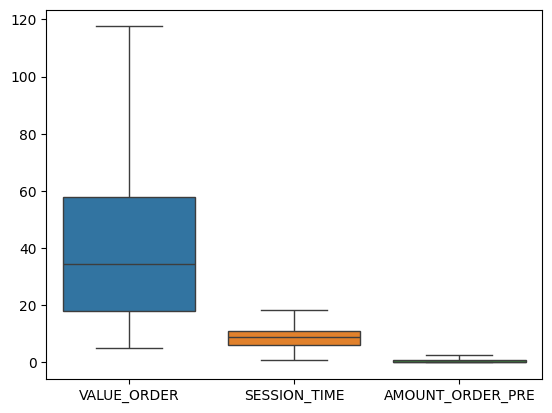

In [346]:
sns.boxplot(data=x[outlier_cols])
plt.show()

In [347]:
num_cols = x.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
x[num_cols] = scaler.fit_transform(x[num_cols])

In [348]:
cat_cols = x.select_dtypes(include=["object"]).columns
x = pd.get_dummies(x, columns=cat_cols, drop_first=True)

In [349]:
x.head()

,Z_CARD_VALID,VALUE_ORDER,AMOUNT_ORDER,ANUMMER_01,SESSION_TIME,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,AGE,B_EMAIL_yes,B_TELEFON_yes,...,DATE_LORDER_9/9/2001,DATE_LORDER_9/9/2002,DATE_LORDER_9/9/2003,DATE_LORDER_9/9/2004,MAHN_AKT_1,MAHN_AKT_2,MAHN_AKT_3,MAHN_HOECHST_1,MAHN_HOECHST_2,MAHN_HOECHST_3
0,-0.426716,-0.827978,-0.47988,0.508802,-0.148307,-0.837658,-0.520647,-0.237580,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1.591608,-0.814389,-0.47988,1.826731,1.154117,-0.837658,-0.520647,0.089340,True,True,...,False,False,False,False,False,False,False,False,False,False
2,1.591608,-1.065784,-0.47988,0.505401,-1.450731,-0.837658,-0.520647,-0.128607,True,False,...,False,False,False,False,False,False,False,False,False,False
3,-1.579998,0.418806,-0.47988,-0.166326,0.633147,2.721895,0.798936,0.525233,False,True,...,False,False,False,False,False,False,False,False,False,False
4,1.591579,-0.753578,-0.47988,-0.889924,1.935572,-0.837658,-0.520647,0.198313,True,True,...,False,False,False,False,False,False,False,False,False,False


In [350]:
data_combined = x.copy()
data_combined["CLASS"] = y.values

count_yes = data_combined[data_combined["CLASS"] == "yes"].shape[0]
count_no = data_combined[data_combined["CLASS"] == "no"].shape[0]

if count_no > count_yes:
    no_samples = data_combined[data_combined["CLASS"] == "no"].sample(count_yes, random_state=42)
    yes_samples = data_combined[data_combined["CLASS"] == "yes"]
    balanced_data = pd.concat([yes_samples, no_samples])
else:
    balanced_data = data_combined

X_balanced = balanced_data.drop("CLASS", axis=1)
y_balanced = balanced_data["CLASS"]

In [351]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [352]:
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)
lr_pred = lr_model.predict(X_val)

acc_rf = accuracy_score(y_val, rf_pred)
acc_lr = accuracy_score(y_val, lr_pred)

print("Random Forest Accuracy:", acc_rf)
print("Logistic Regression Accuracy:", acc_lr)

Random Forest Accuracy: 0.6680972818311874
Logistic Regression Accuracy: 0.6466380543633763


In [353]:
final_model = lr_model

In [354]:
test_df = pd.read_csv(test_data, delimiter="\t")

order_ids = test_df["ORDER_ID"]

test_df.replace("?", np.nan, inplace=True)

In [355]:
test_df.shape

(20000, 43)

In [356]:
missing_val_testdata = test_df.isnull().sum()
missing_val_testdata[missing_val_testdata >  (0.6 * len(test_df))]

,0
Z_CARD_ART,12317
ANUMMER_02,14905
ANUMMER_03,17907
ANUMMER_04,19123
ANUMMER_05,19636
ANUMMER_06,19855
ANUMMER_07,19935
ANUMMER_08,19971
ANUMMER_09,19982
ANUMMER_10,19987


In [357]:
columns_to_drop = missing_val_testdata[missing_val_testdata > (0.6 * len(test_df))].index
test_df.drop(columns=columns_to_drop, inplace=True)

In [358]:
test_df.isnull().sum()

,0
ORDER_ID,0
B_EMAIL,0
B_TELEFON,0
B_BIRTHDATE,2054
FLAG_LRIDENTISCH,0
FLAG_NEWSLETTER,0
Z_METHODE,0
Z_CARD_VALID,0
Z_LAST_NAME,9706
VALUE_ORDER,0


In [359]:
for col in test_df.columns:
    if test_df[col].dtype == "object":
        test_df[col].fillna(test_df[col].mode()[0], inplace=True)
    else:
        test_df[col].fillna(test_df[col].mean(), inplace=True)

In [360]:
test_df.isnull().sum()

,0
ORDER_ID,0
B_EMAIL,0
B_TELEFON,0
B_BIRTHDATE,0
FLAG_LRIDENTISCH,0
FLAG_NEWSLETTER,0
Z_METHODE,0
Z_CARD_VALID,0
Z_LAST_NAME,0
VALUE_ORDER,0


In [361]:
test_df.drop("ORDER_ID", axis=1, inplace=True)

In [362]:
if "B_BIRTHDATE" in test_df.columns:
    test_df["B_BIRTHDATE"] = pd.to_datetime(test_df["B_BIRTHDATE"], errors="coerce")
    current_year = pd.Timestamp.now().year
    test_df["AGE"] = current_year - test_df["B_BIRTHDATE"].dt.year
    test_df.drop("B_BIRTHDATE", axis=1, inplace=True)


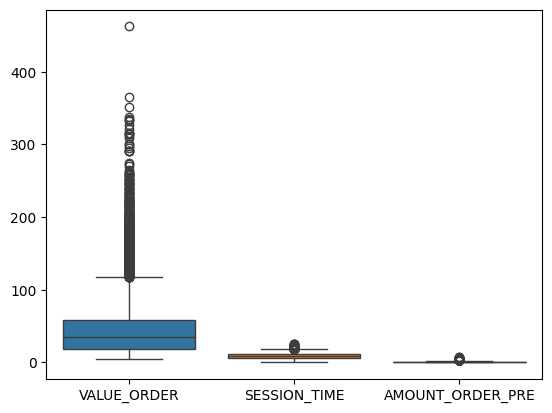

In [363]:
sns.boxplot(data=test_df[outlier_cols])
plt.show()

In [364]:
for col in outlier_cols:
    if col in test_df.columns:
        Q1 = test_df[col].quantile(0.25)
        Q3 = test_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        test_df[col] = np.where(test_df[col] < lower_bound, lower_bound, test_df[col])
        test_df[col] = np.where(test_df[col] > upper_bound, upper_bound, test_df[col])

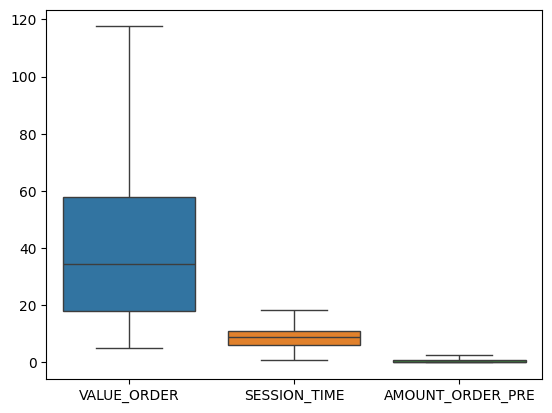

In [365]:
sns.boxplot(data=test_df[outlier_cols])
plt.show()

In [366]:
num_cols_test = test_df.select_dtypes(include=[np.number]).columns
num_cols_test

Index(['Z_CARD_VALID', 'VALUE_ORDER', 'AMOUNT_ORDER', 'ANUMMER_01',
       'SESSION_TIME', 'AMOUNT_ORDER_PRE', 'VALUE_ORDER_PRE', 'AGE'],
      dtype='object')

In [367]:
test_df[num_cols_test] = scaler.transform(test_df[num_cols_test])


In [368]:
cat_cols_test = test_df.select_dtypes(include=["object"]).columns
cat_cols_test

Index(['B_EMAIL', 'B_TELEFON', 'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER',
       'Z_METHODE', 'Z_LAST_NAME', 'WEEKDAY_ORDER', 'TIME_ORDER', 'CHK_LADR',
       'CHK_RADR', 'CHK_KTO', 'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ',
       'FAIL_LORT', 'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT',
       'FAIL_RPLZORTMATCH', 'NEUKUNDE', 'DATE_LORDER', 'MAHN_AKT',
       'MAHN_HOECHST'],
      dtype='object')

In [369]:
test_df = pd.get_dummies(test_df, columns=cat_cols_test, drop_first=True)
test_df.head()

,Z_CARD_VALID,VALUE_ORDER,AMOUNT_ORDER,ANUMMER_01,SESSION_TIME,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,AGE,B_EMAIL_yes,B_TELEFON_yes,...,DATE_LORDER_9/9/2001,DATE_LORDER_9/9/2002,DATE_LORDER_9/9/2003,DATE_LORDER_9/9/2004,MAHN_AKT_1,MAHN_AKT_2,MAHN_AKT_3,MAHN_HOECHST_1,MAHN_HOECHST_2,MAHN_HOECHST_3
0,-1.291728,0.758529,-0.479880,1.880007,-0.669277,-0.837658,-0.520647,-0.891419,True,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.715072,1.091457,2.775751,0.463407,0.112178,0.586163,0.007569,-0.237580,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.438239,0.021330,-0.479880,0.505224,-0.929762,-0.837658,-0.520647,0.089340,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0.149940,0.021330,-0.479880,0.488171,1.154117,0.586163,0.421638,-1.545258,True,False,...,False,False,False,False,False,False,False,True,False,False
4,-0.426687,-1.211865,-0.479880,-0.878770,-0.148307,-0.837658,-0.520647,0.852152,False,True,...,False,False,False,False,False,False,False,False,False,False


In [370]:
test_df = test_df.reindex(columns=x.columns, fill_value=0)
test_df.head()

,Z_CARD_VALID,VALUE_ORDER,AMOUNT_ORDER,ANUMMER_01,SESSION_TIME,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,AGE,B_EMAIL_yes,B_TELEFON_yes,...,DATE_LORDER_9/9/2001,DATE_LORDER_9/9/2002,DATE_LORDER_9/9/2003,DATE_LORDER_9/9/2004,MAHN_AKT_1,MAHN_AKT_2,MAHN_AKT_3,MAHN_HOECHST_1,MAHN_HOECHST_2,MAHN_HOECHST_3
0,-1.291728,0.758529,-0.479880,1.880007,-0.669277,-0.837658,-0.520647,-0.891419,True,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.715072,1.091457,2.775751,0.463407,0.112178,0.586163,0.007569,-0.237580,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.438239,0.021330,-0.479880,0.505224,-0.929762,-0.837658,-0.520647,0.089340,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0.149940,0.021330,-0.479880,0.488171,1.154117,0.586163,0.421638,-1.545258,True,False,...,False,False,False,False,False,False,False,True,False,False
4,-0.426687,-1.211865,-0.479880,-0.878770,-0.148307,-0.837658,-0.520647,0.852152,False,True,...,False,False,False,False,False,False,False,False,False,False


In [371]:
predictions = final_model.predict(test_df)

In [372]:
predictions

array(['no', 'no', 'yes', ..., 'yes', 'no', 'no'], dtype=object)

In [373]:
output_df = pd.DataFrame({"ORDER_ID": order_ids, "CLASS": predictions})
output_df.to_csv("predictions.txt", sep="\t", index=False)